In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.io as io
from pathlib import Path
import numpy as np

%matplotlib inline

color_dict = [0, 127, 255]
classweights = [1.0, 1.503971686212565, 1.9888096014508438]

In [2]:
def labelVisualize(num_class,color_dict,img):
    img
    print(np.unique(img))
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        print(img_out[img == i,:])
        img_out[img == i,:] = color_dict[i]
    return img_out# / 255

In [3]:
def softmax(vec, weight):
    exp = weight*np.exp(vec)
    return exp/np.sum(exp)

In [29]:
def show_prediction(n, sat, map, predict):
    sat = io.imread(sat)
    q = io.imread(predict)
    
    p = q
    s = np.shape(q)
    k = np.zeros((s[0], s[1]))
    numUn = 0
    numP = 0
    for i in range(len(q[0])):
        for j in range(len(q[1])):
            if np.argmax(q[i,j,:]) == 1:
                #print(np.argmax(softmax(q[i,j,:], classweights)))
                numP += 1
            elif np.argmax(q[i,j,:]) == 2:
                numUn += 1
            p[i,j,(np.argmax(q[i,j,:]))] = 1
            k[i, j] = (np.argmax(q[i,j,:]))*127
    map = io.imread(map)
#     map = map.reshape((512,512))
    figH1 = plt.figure(n, figsize=(25, 6))
    plt.subplot(1, 5, 1)
    plt.imshow(sat)
    
    plt.subplot(1, 5, 2)
    plt.imshow(map, cmap='gray')

    plt.subplot(1, 5, 3)
    plt.imshow(k, cmap='gray')
    plt.subplot(1, 5, 4)
    plt.imshow(p[..., 1], cmap='gray')
    plt.subplot(1, 5, 5)
    plt.imshow(p[..., 2], cmap='gray')

    plt.colorbar()
    figH1.show()
    print(numUn, numP)

In [30]:
test_dir="../../data/test/"

In [31]:
def get_image_paths(file_name):
    sat_rgb = test_dir + "sat_rgb/" + file_name
    map =  test_dir + "map/" + file_name
    predict = test_dir + "predict/" + file_name
    return {"sat": sat_rgb, "map": map, "predict":predict}

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0 610
0 1436
0 2369
0 1783
0 1305
0 3661
0 5483
0 675
0 3055
0 2357
0 3524
0 744
0 272
0 1728
0 2931
0 567
0 3963
0 2540
0 2578


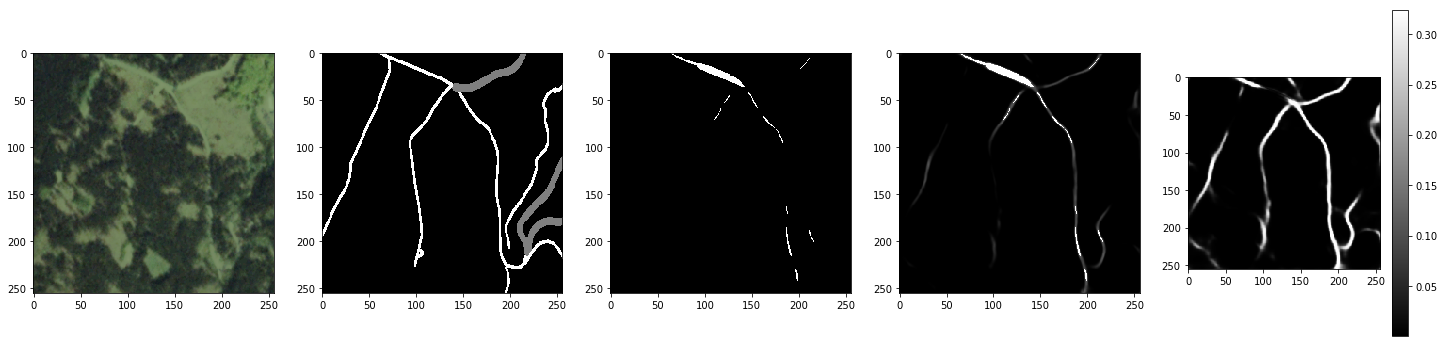

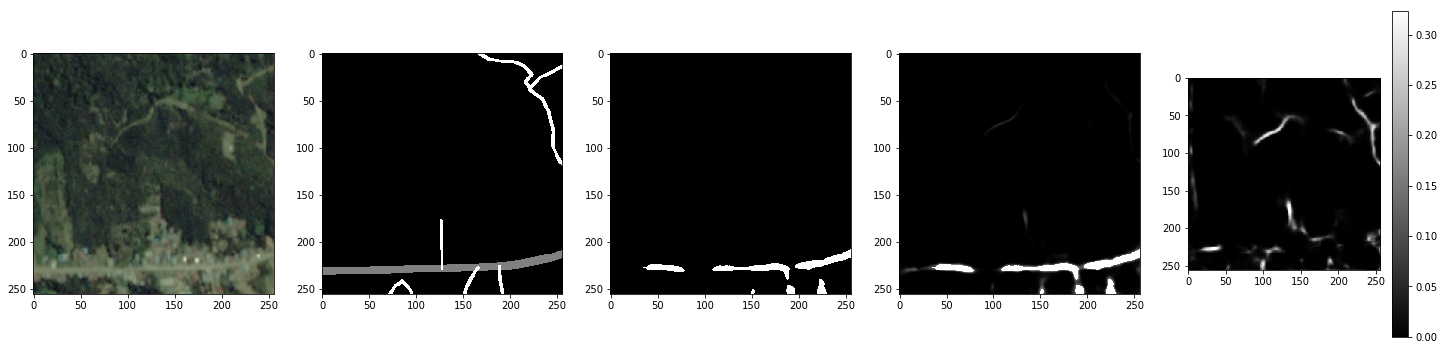

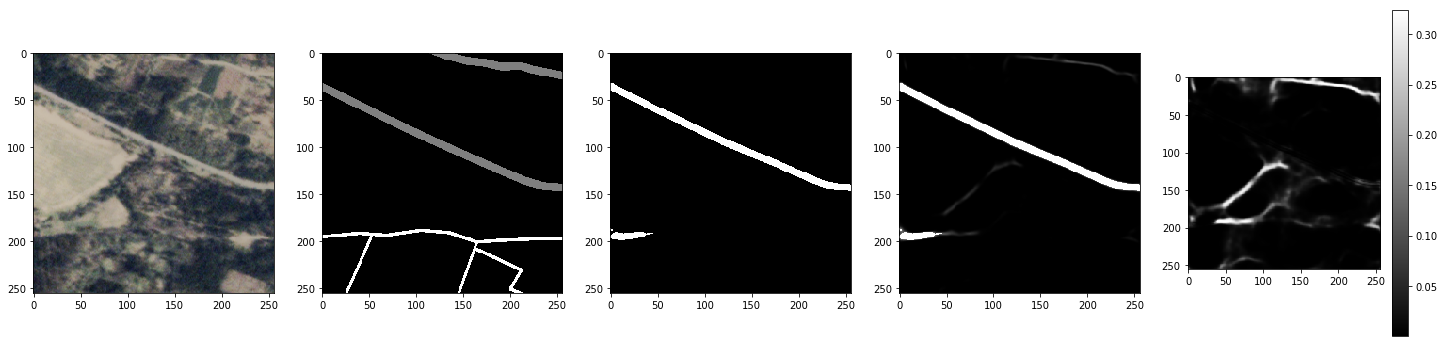

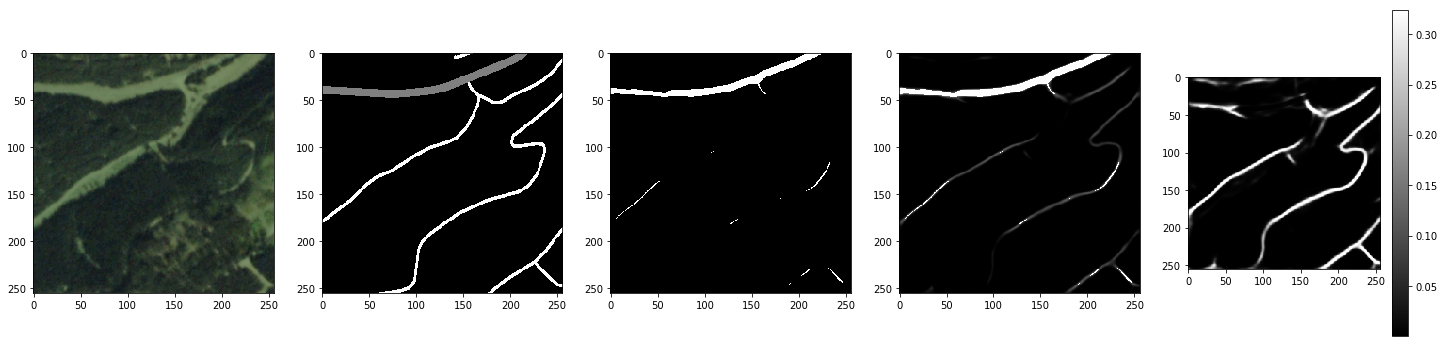

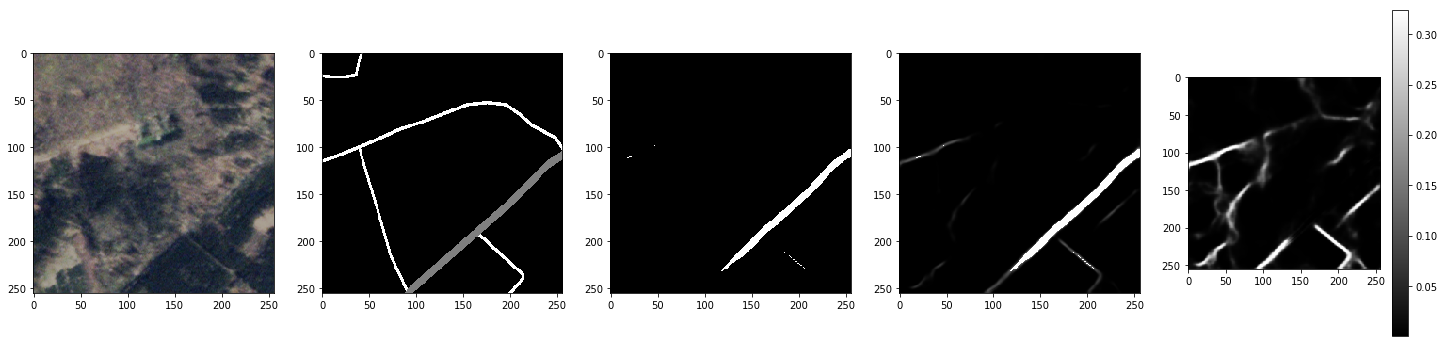

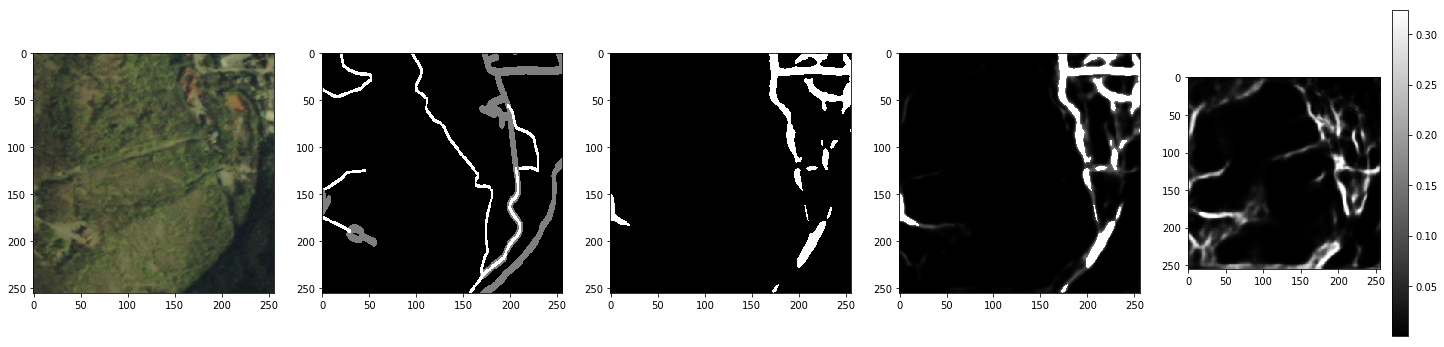

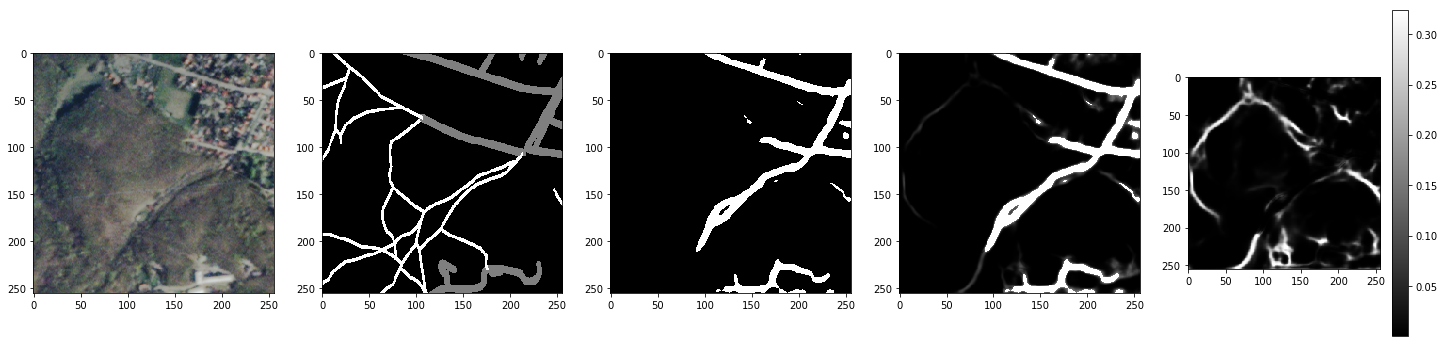

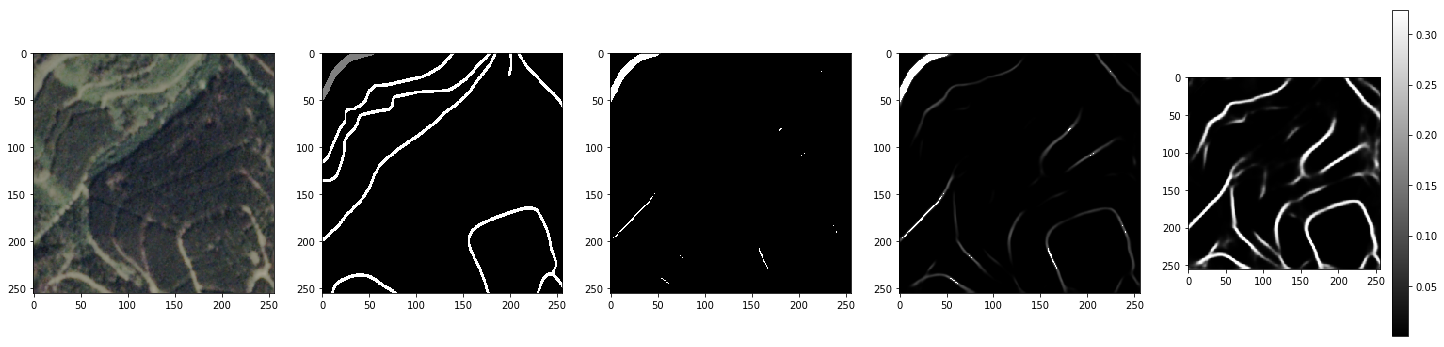

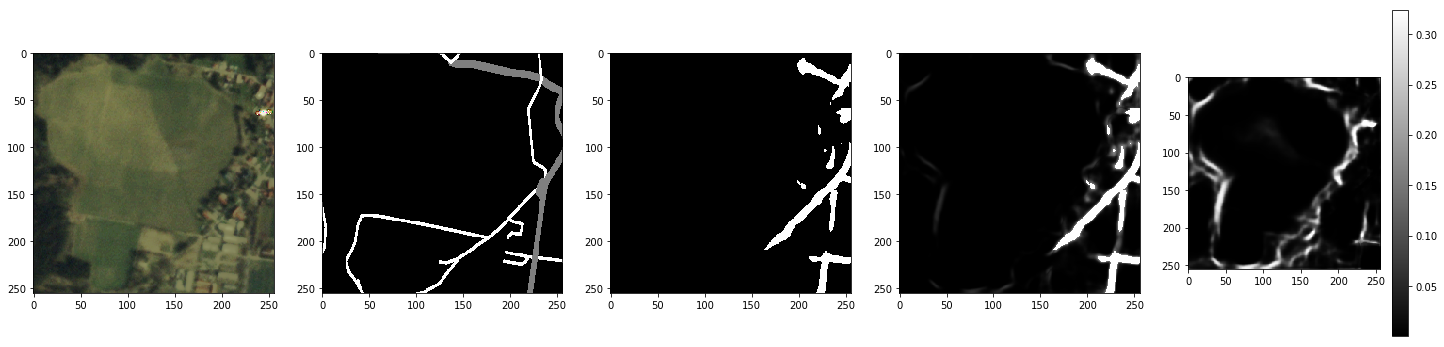

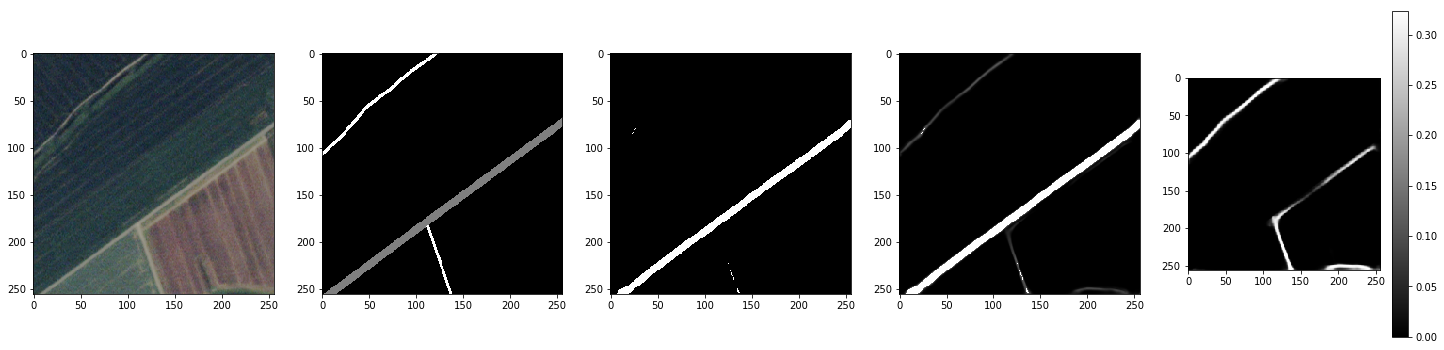

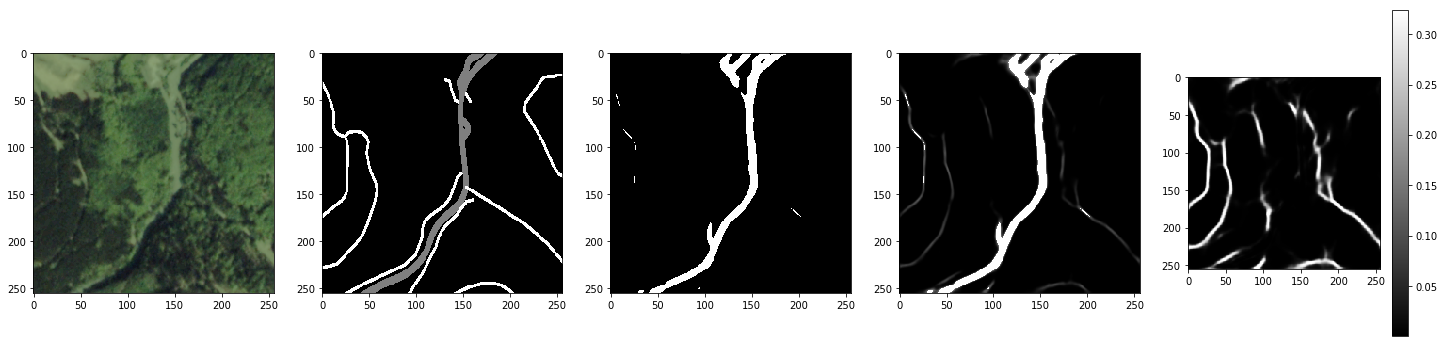

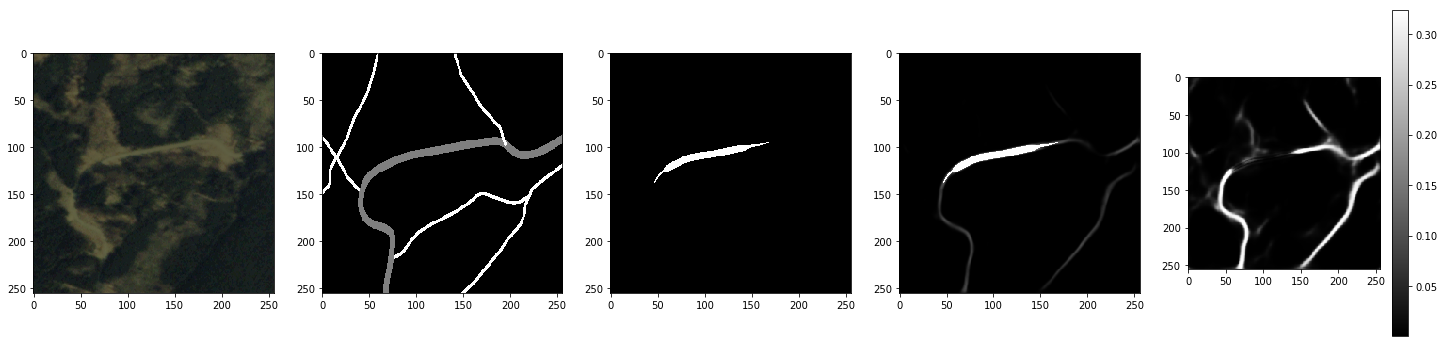

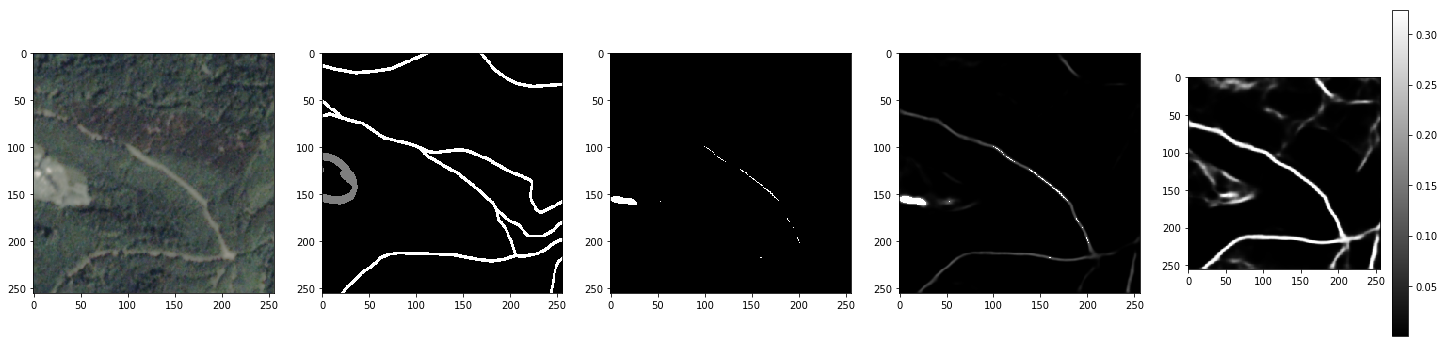

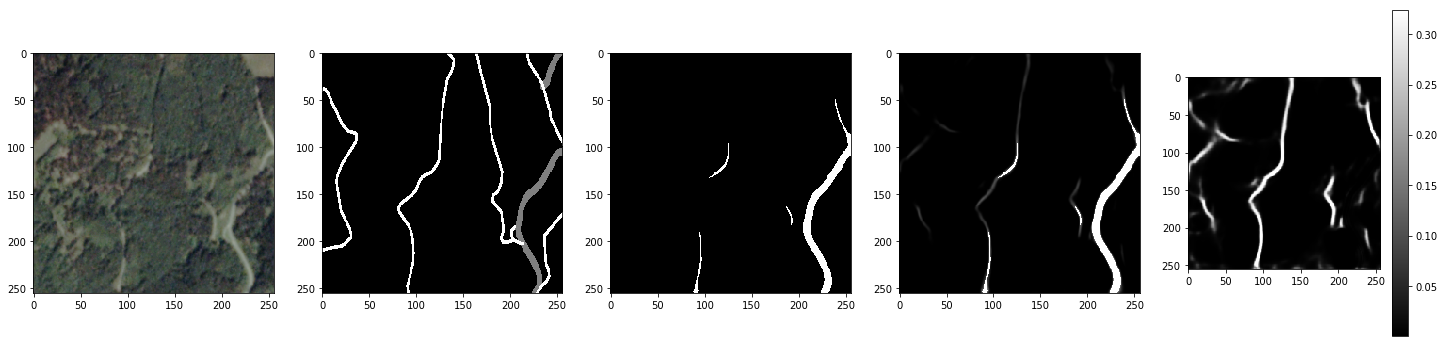

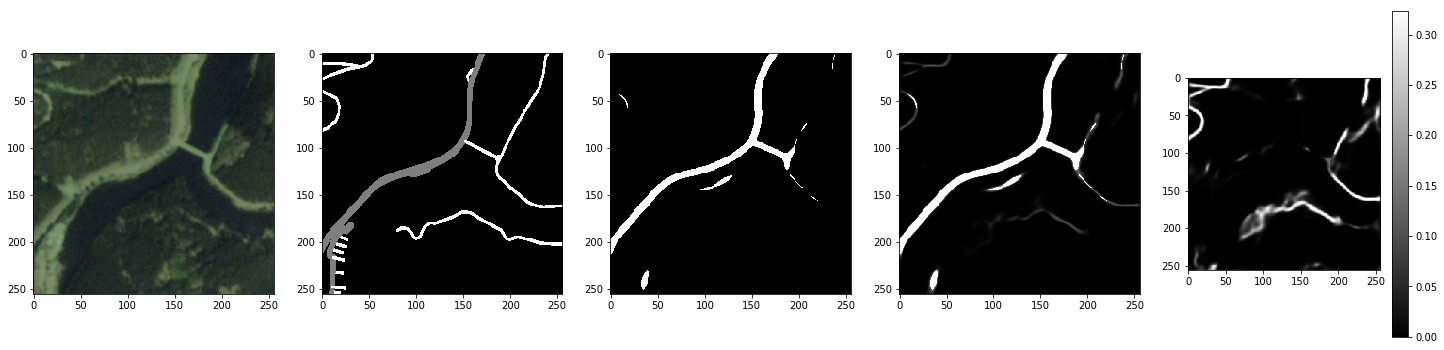

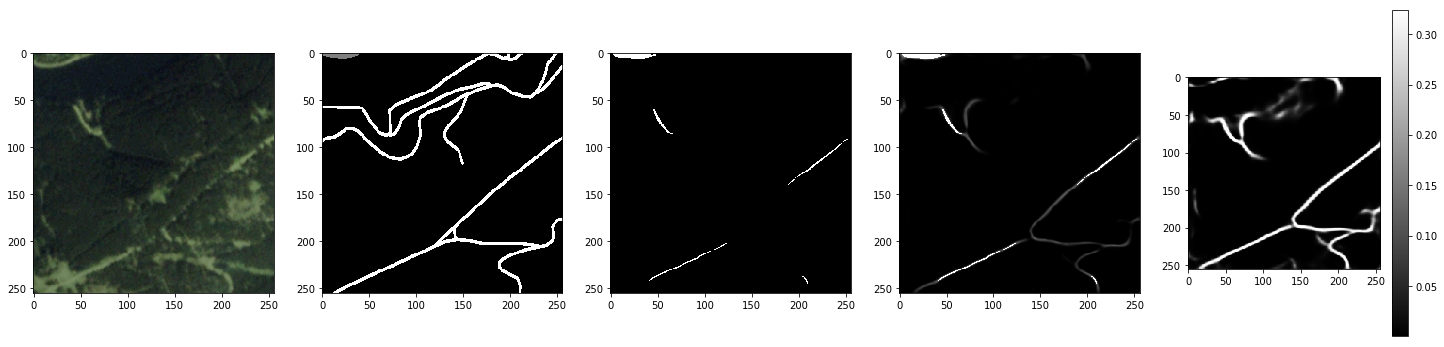

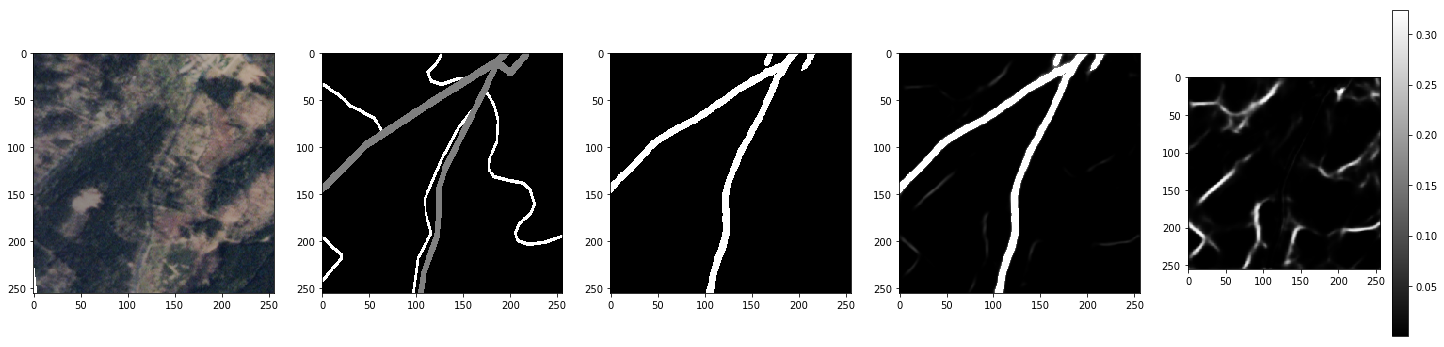

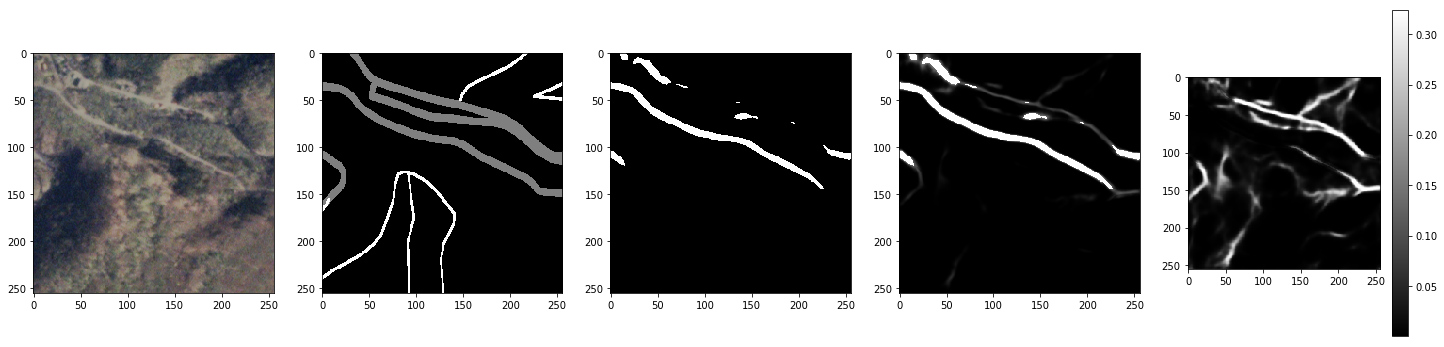

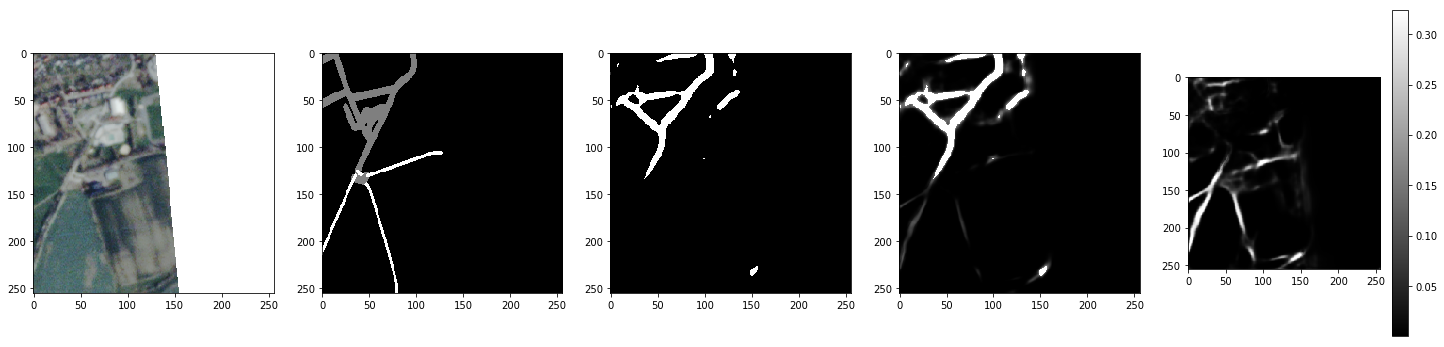

In [37]:
n = 0
for file in Path(test_dir+"sat").iterdir():
    if file.name.endswith(('.tiff', '.tif')):
        
        show_prediction(n, **get_image_paths(file.name))
        n +=1
        if(n>20):
            break

In [33]:
print(np.exp([.0000000001])/np.exp([1.]))

[0.36787944]
